## Import Libraries

In [2]:
# Getting file path
import os

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
# Plotting and configuration
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
from tqdm import tqdm               
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

# For regex
import re

## Data Preparation

### To get the training and validation set from the images

In [37]:
X=[]
Z=[]
IMG_SIZE=150

In [38]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label = flower_type
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [39]:
def get_dir_label(DIR):
    dir_dict = {}
    for class_label in os.listdir(DIR):
        flower_name = class_label.capitalize()
        flower_dir = DIR +'/'+ class_label
        dir_dict[flower_name] = flower_dir
    return dir_dict

In [40]:
label= get_dir_label('./flowers')
for k,v in label.items():
    make_train_data(k,v)

100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 44.46it/s]


### Visualizing Some Random Images

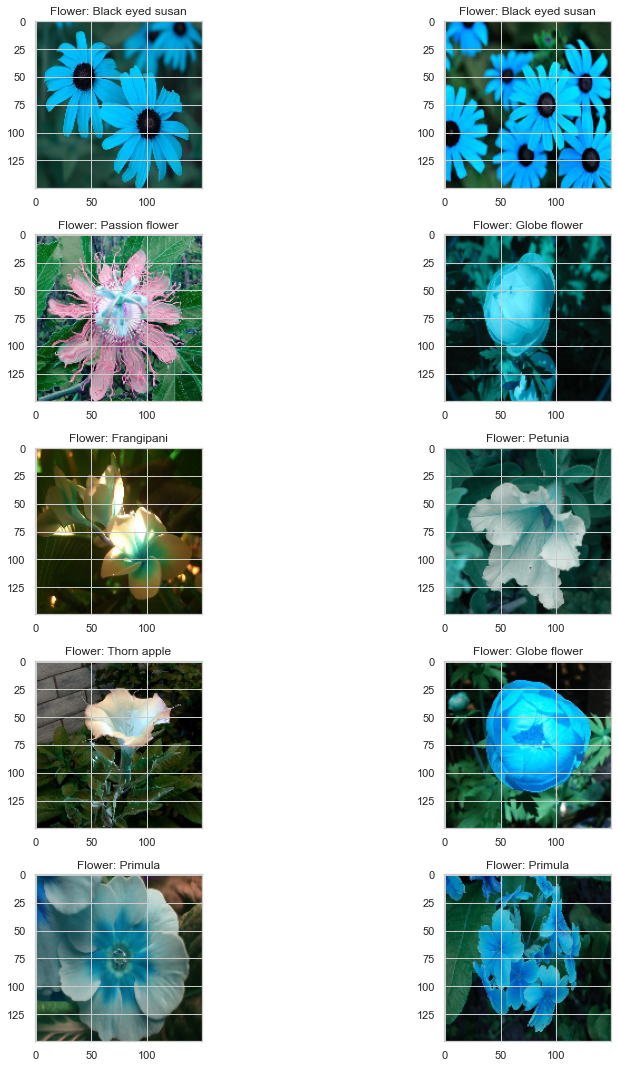

In [41]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

### Normalization and One Hot Encoding

In [42]:
# Normalize data
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,len(Z))
X=np.array(X)
X=X/255

## Split Data for Training and Test

### Splitting into Training and Validation

In [43]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

### Setting the Random Seeds

In [44]:
# To resolve randomness of the model result
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

## Building the Model

### Building ConvNet Model

In [80]:
# modelling starts using a CNN.
# Uses RELU and Softmax for activation function

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(Z), activation = "softmax"))

### Using LR Annealer

In [81]:
batch_size=64
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

### Data Augmentation to Prevent Overfitting

In [82]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.25, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## Compilation

### Compiling the Keras Model & Summary

In [83]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [84]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 18, 18, 96)      

## Fitting on the Training set and making prediction on Validation set

In [85]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)


Epoch 1/50
39/39 [==============================] - 70s 2s/step - loss: 3.9694 - accuracy: 0.0437 - val_loss: 3.0037 - val_accuracy: 0.1277
Epoch 2/50
39/39 [==============================] - 68s 2s/step - loss: 2.9369 - accuracy: 0.0865 - val_loss: 2.4967 - val_accuracy: 0.1891
Epoch 3/50
39/39 [==============================] - 67s 2s/step - loss: 2.5698 - accuracy: 0.1593 - val_loss: 2.3333 - val_accuracy: 0.2270
Epoch 4/50
39/39 [==============================] - 67s 2s/step - loss: 2.2630 - accuracy: 0.2829 - val_loss: 1.8172 - val_accuracy: 0.3853
Epoch 5/50
39/39 [==============================] - 68s 2s/step - loss: 1.9705 - accuracy: 0.3856 - val_loss: 1.6021 - val_accuracy: 0.4823
Epoch 6/50
39/39 [==============================] - 69s 2s/step - loss: 1.7563 - accuracy: 0.4260 - val_loss: 1.5289 - val_accuracy: 0.5366
Epoch 7/50
39/39 [==============================] - 71s 2s/step - loss: 1.6875 - accuracy: 0.4640 - val_loss: 1.3220 - val_accuracy: 0.5768
Epoch 8/50
39/39 [==

## 4. Evaluation

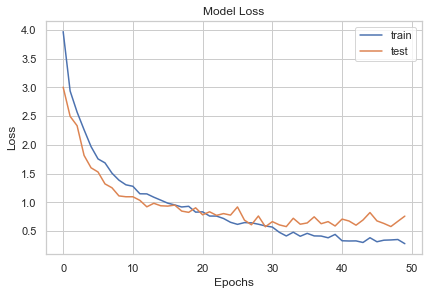

The loss value is:  0.2824922204017639
The val loss value is:  0.7617490291595459


In [86]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

print('The loss value is: ', History.history['loss'][-1])
print('The val loss value is: ', History.history['val_loss'][-1])

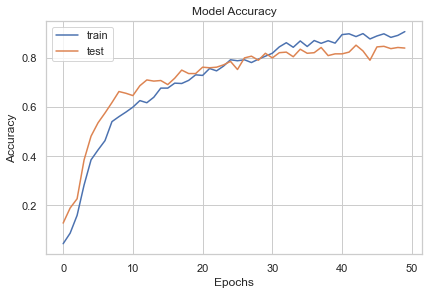

The accuracy of the model is:  90 %
The val accuracy of the model is:  84 %


In [87]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

print('The accuracy of the model is: ', int(History.history['accuracy'][-1] * 100), '%')
print('The val accuracy of the model is: ', int(History.history['val_accuracy'][-1] * 100), '%')

## 5. Visualizing Predictions on the Validation Set

In [61]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

15/15 [==============================] - 7s 448ms/step


In [62]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)


## Result

### Classified Images

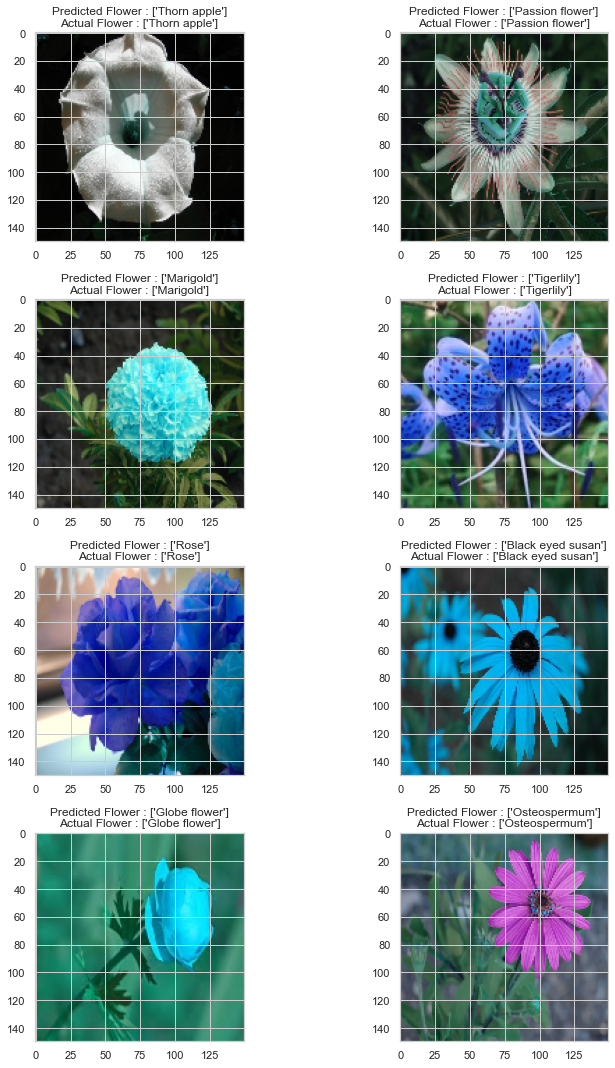

In [30]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax(y_test[prop_class[count]])])))
        plt.tight_layout()
        count+=1
        

### Misclassified Images

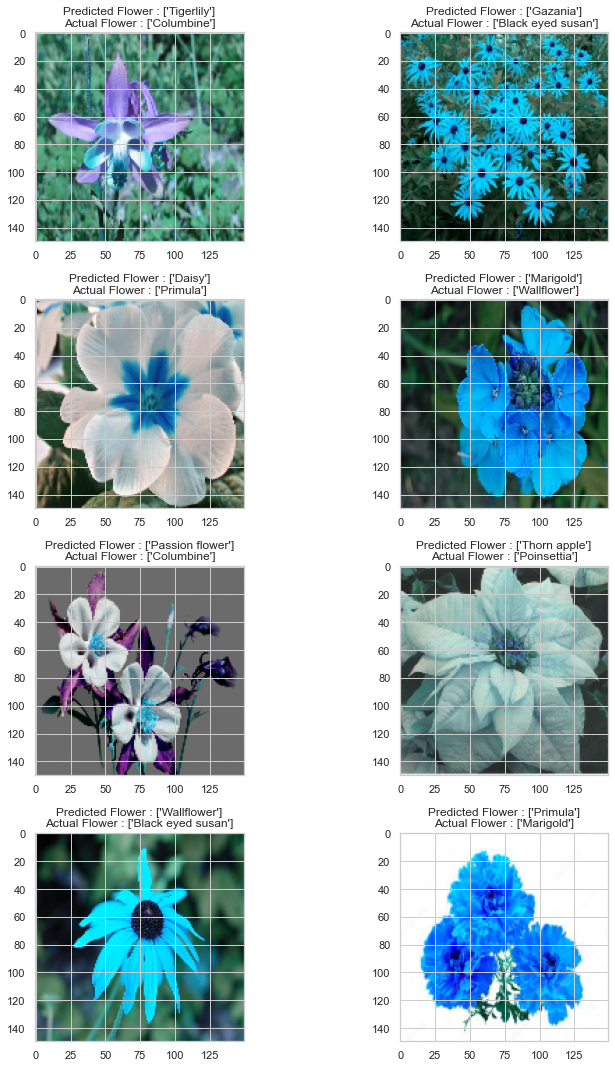

In [31]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range(4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax(y_test[mis_class[count]])])))
        plt.tight_layout()
        count+=1